In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

import seaborn as sns

from sklearn.metrics import f1_score

In [2]:
def Format_Test_Data(var_data_file, var_rows_to_load, var_scaler):
    # Load and preprocess the data
    data = pd.read_csv(var_data_file, nrows=var_rows_to_load)
    
    print("original DataFrame:")
    display(data)
    
    # restructure columns here so that label is the last column:
    var_final_dataset_column_list = data.columns.tolist()
    
    # remove the "label" column here and append it at the end of the list:
    var_final_dataset_column_list.remove("label")
    var_final_dataset_column_list.remove("time")
    var_final_dataset_column_list.remove("tonic_entropy")

    var_final_dataset_column_list.remove("acc_x")
    var_final_dataset_column_list.remove("acc_y")
    var_final_dataset_column_list.remove("acc_z")
    var_final_dataset_column_list.remove("seconds")

    
    var_final_dataset_column_list.append("label")
    data = data[var_final_dataset_column_list]
    
    var_final_dataset_column_list_final = var_final_dataset_column_list.copy()
      
    for var_column in var_final_dataset_column_list:
        nan_count = data[var_column].isna().sum()
        if nan_count > 0:
            # drop this column here:
            print("column has NaN:")
            print(var_column,nan_count)
            var_final_dataset_column_list_final.remove(var_column)
            
        inf_count = data[var_column].map(np.isinf).sum()
        #print(inf_count)
        if inf_count > 0:
            # drop this column here:
            print()
            print("column has Inf:")
            print(var_column,inf_count)
            if var_column in var_final_dataset_column_list_final:
                var_final_dataset_column_list_final.remove(var_column)
        
        #print(var_column[0:5])
        # remove survey columns here:
        if var_column[0:5] == "PANAS" or var_column[0:4] == "STAI" or var_column[0:4] == "SAM0":
            # drop this column here:
            print()
            print("column has Survey Data:")
            print(var_column)
            if var_column in var_final_dataset_column_list_final:
                var_final_dataset_column_list_final.remove(var_column)
            
            
        
    #data.dropna(inplace=True)
    # Remove the first column
    #first_column_name = data.columns[0]
    #data = data.drop(columns=first_column_name)
    
    # remove all columns which have NaN here:
    data = data[var_final_dataset_column_list_final]
    
    data = data[(data['label'] < 5) & (data['label'] > 0)]
    
    data = data.iloc[:,1:]
    
    print("DataFrame (after NaN and Inf removed):")
    display(data)
    print("columns names after removal = ")
    print(data.columns)    
    
    #data.dropna(inplace=True)

    data.to_csv('Capstone_TEST_dataset_for_ml_50ms.csv', index=False)
    

    
    var_feature_columns = data.columns[:-1]
    # Difference the DataFrame at the 1-second level (20 rows)
    #data.iloc[:,:-1] = data.iloc[:,:-1].diff(periods=20)
    #data = data.dropna()
    
    # labels should be 1 - 4.... change them to be 0 to 3 for the NN to work correctly here:
    data['label'] = data['label'] - 1
    
    unique_labels = data['label'].unique()

    # Print the unique values
    print("Unique values in TEST 'label' column:", unique_labels)
    
    X_test = data[var_feature_columns].values
    y_test = data['label'].values


    # Scale the X "Test" features between 0 and 1
    X_test = var_scaler.transform(X_test)
    
    return [X_test,y_test, data.columns]

In [3]:
def Load_StandardTrainTestSplit_timeseries_Xy(var_data_file, var_rows_to_load, var_test_size=0.2):
    # Load and preprocess the data
    data = pd.read_csv(var_data_file, nrows=var_rows_to_load)
    
    print("original DataFrame:")
    display(data)
    
    # restructure columns here so that label is the last column:
    var_final_dataset_column_list = data.columns.tolist()
    
    # remove the "label" column here and append it at the end of the list:
    var_final_dataset_column_list.remove("label")
    var_final_dataset_column_list.remove("time")
    var_final_dataset_column_list.remove("tonic_entropy")
    
    var_final_dataset_column_list.remove("acc_x")
    var_final_dataset_column_list.remove("acc_y")
    var_final_dataset_column_list.remove("acc_z")
    var_final_dataset_column_list.remove("seconds")

    
    var_final_dataset_column_list.append("label")
    data = data[var_final_dataset_column_list]
    
    var_final_dataset_column_list_final = var_final_dataset_column_list.copy()
      
    for var_column in var_final_dataset_column_list:
        nan_count = data[var_column].isna().sum()
        if nan_count > 0:
            # drop this column here:
            print("column has NaN:")
            print(var_column,nan_count)
            var_final_dataset_column_list_final.remove(var_column)
            
        inf_count = data[var_column].map(np.isinf).sum()
        #print(inf_count)
        if inf_count > 0:
            # drop this column here:
            print()
            print("column has Inf:")
            print(var_column,inf_count)
            if var_column in var_final_dataset_column_list_final:
                var_final_dataset_column_list_final.remove(var_column)
        
        #print(var_column[0:5])
        # remove survey columns here:
        if var_column[0:5] == "PANAS" or var_column[0:4] == "STAI" or var_column[0:4] == "SAM0":
            # drop this column here:
            print()
            print("column has Survey Data:")
            print(var_column)
            if var_column in var_final_dataset_column_list_final:
                var_final_dataset_column_list_final.remove(var_column)
            
            
        
    #data.dropna(inplace=True)
    # Remove the first column
    #first_column_name = data.columns[0]
    #data = data.drop(columns=first_column_name)
    
    # remove all columns which have NaN here:
    data = data[var_final_dataset_column_list_final]
    
    data = data.iloc[:,2:]
    
    print("DataFrame (after NaN and Inf removed):")
    display(data)
    
    print("columns names after removal = ")
    print(data.columns)
    
    
    #data.dropna(inplace=True)

    data.to_csv('Capstone_final_final_dataset_for_ml_50ms.csv', index=False)
       
    var_feature_columns = data.columns[:-1]
    ## Difference the DataFrame at the 1-second level (20 rows)
    #data.iloc[:,:-1] = data.iloc[:,:-1].diff(periods=20)
    #data = data.dropna()
    
    # labels should be 1 - 4.... change them to be 0 to 3 for the NN to work correctly here:
    data['label'] = data['label'] - 1
    
    X = data[var_feature_columns].values
    y = data['label'].values
    
    unique_labels = data['label'].unique()

    # Print the unique values
    print("Unique values in TRAIN 'label' column:", unique_labels)

    # Split data into train and test sets
    #####X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=var_test_size, random_state=42)
    
    # Split data into train and test sets
    var_80_percent_mark = int(.8 * len(X))
    print("var_80_percent_mark = ")
    print(var_80_percent_mark)
    train_X_data = X[:var_80_percent_mark, :]
    test_X_data = X[var_80_percent_mark:, :]

    train_y_data = y[:var_80_percent_mark]
    test_y_data = y[var_80_percent_mark:]

    X_train = train_X_data
    X_test = test_X_data
    y_train = train_y_data
    y_test = test_y_data
    
    var_print_bool = True
    
    if var_print_bool:
        print("X and y train / test before scale function:")
        var_X_train_df = pd.DataFrame(X_train)
        var_X_test_df = pd.DataFrame(X_test)
        var_y_train_df = pd.DataFrame(y_train)
        var_y_test_df = pd.DataFrame(y_test)
    
        print("var_X_train_df = ")
        display(var_X_train_df)

        print("var_X_test_df = ")
        display(var_X_test_df)

        print("var_y_train_df = ")
        display(var_y_train_df)

        print("var_y_test_df = ")
        display(var_y_test_df)

    # Scale the X "Train" features between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train = scaler.fit_transform(X_train)

    # Scale the X "Test" features between 0 and 1
    X_test = scaler.transform(X_test)
    
    unique_labels_y_train = np.unique(y_train)

    # Print the unique values
    print("Unique values in TRAIN 'label' column:", unique_labels_y_train)
    
    unique_labels_y_test = np.unique(y_test)

    # Print the unique values
    print("Unique values in TEST 'label' column:", unique_labels_y_test)
    
    return [(X_train,X_test,y_train,y_test), data, data.columns, scaler]

In [4]:

#var_data_file_name = 'Capstone_NN_Training_Data_Inputs_non_scaled_version_100ms.csv'
var_data_file_name = 'Capstone_final_dataset_for_ml_50ms.csv'
#var_n_rows_to_load = 200000
#var_n_rows_to_load = 20000

#load all:
var_n_rows_to_load = None

var_test_size = .25
var_verbose = True

var_return = Load_StandardTrainTestSplit_timeseries_Xy(var_data_file_name, var_n_rows_to_load, var_test_size)
X_train,X_test,y_train,y_test = var_return[0]
var_data_df = var_return[1]
var_train_data_df_column_list = var_return[2]

var_scaler_from_training = var_return[3]

original DataFrame:


,Unnamed: 0,subject,label,time,ACC_1,ACC_2,ACC_3,ECG,EMG,EDA,...,tonic_rms,tonic_entropy,phasic_mean,phasic_std,phasic_min,phasic_max,phasic_energy,phasic_peaks,phasic_rms,phasic_entropy
0,0,2,1,1970-01-01 00:00:00.000,0.889131,-0.104177,-0.254086,0.052203,0.000302,5.712509,...,12.093175,-inf,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,12.524029
1,1,2,1,1970-01-01 00:00:00.050,0.889731,-0.100206,-0.242897,0.076138,-0.005188,5.707354,...,12.093175,-inf,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,12.524029
2,2,2,1,1970-01-01 00:00:00.100,0.893480,-0.103223,-0.248234,0.073135,-0.003722,5.698667,...,12.093175,-inf,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,12.524029
3,3,2,1,1970-01-01 00:00:00.150,0.878366,-0.113154,-0.236754,0.054067,0.000221,5.692651,...,12.093175,-inf,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,12.524029
4,4,2,1,1970-01-01 00:00:00.200,0.890411,-0.117394,-0.238989,0.058294,-0.003258,5.685992,...,12.093175,-inf,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,12.524029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718272,718272,14,4,1970-01-01 09:58:30.800,0.759880,0.057206,-0.539423,0.040534,-0.004145,2.928292,...,5.484862,-inf,2.843061,5.237621,0.0,26.892228,8.132271e+06,9.0,5.959502,11.285276
718273,718273,14,4,1970-01-01 09:58:30.850,0.756909,0.059520,-0.539331,-0.188461,-0.003279,2.927660,...,5.484862,-inf,2.843061,5.237621,0.0,26.892228,8.132271e+06,9.0,5.959502,11.285276
718274,718274,14,4,1970-01-01 09:58:30.900,0.750143,0.062286,-0.554251,-0.173746,-0.002144,2.926516,...,5.484862,-inf,2.843061,5.237621,0.0,26.892228,8.132271e+06,9.0,5.959502,11.285276
718275,718275,14,4,1970-01-01 09:58:30.950,0.752429,0.060760,-0.540189,-0.133898,-0.003318,2.927410,...,5.484862,-inf,2.843061,5.237621,0.0,26.892228,8.132271e+06,9.0,5.959502,11.285276



column has Survey Data:
PANAS01_Active

column has Survey Data:
PANAS02_Distressed

column has Survey Data:
PANAS03_Interested

column has Survey Data:
PANAS04_Inspired

column has Survey Data:
PANAS05_Annoyed

column has Survey Data:
PANAS06_Strong

column has Survey Data:
PANAS07_Guilty

column has Survey Data:
PANAS08_Scared

column has Survey Data:
PANAS09_Hostile

column has Survey Data:
PANAS10_Excited

column has Survey Data:
PANAS11_Proud

column has Survey Data:
PANAS12_Irritable

column has Survey Data:
PANAS13_Enthusiastic

column has Survey Data:
PANAS14_Ashamed

column has Survey Data:
PANAS15_Alert
column has NaN:
PANAS16_Nervous 15882

column has Survey Data:
PANAS16_Nervous

column has Survey Data:
PANAS17_Determined

column has Survey Data:
PANAS18_Attentive

column has Survey Data:
PANAS19_Jittery

column has Survey Data:
PANAS20_Afraid

column has Survey Data:
PANAS21_Stressed

column has Survey Data:
PANAS22_Frustrated

column has Survey Data:
PANAS23_Happy
column 

,ACC_1,ACC_2,ACC_3,ECG,EMG,EDA,Temp,Resp,age,height,...,tonic_peaks,tonic_rms,phasic_mean,phasic_std,phasic_min,phasic_max,phasic_energy,phasic_peaks,phasic_rms,label
0,0.889131,-0.104177,-0.254086,0.052203,0.000302,5.712509,29.119919,1.025521,27.0,175.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,1
1,0.889731,-0.100206,-0.242897,0.076138,-0.005188,5.707354,29.119755,0.710013,27.0,175.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,1
2,0.893480,-0.103223,-0.248234,0.073135,-0.003722,5.698667,29.125584,0.327802,27.0,175.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,1
3,0.878366,-0.113154,-0.236754,0.054067,0.000221,5.692651,29.133441,-0.066877,27.0,175.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,1
4,0.890411,-0.117394,-0.238989,0.058294,-0.003258,5.685992,29.122919,-0.490505,27.0,175.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718272,0.759880,0.057206,-0.539423,0.040534,-0.004145,2.928292,34.231500,0.204075,27.0,180.0,...,7.0,5.484862,2.843061,5.237621,0.0,26.892228,8.132271e+06,9.0,5.959502,4
718273,0.756909,0.059520,-0.539331,-0.188461,-0.003279,2.927660,34.225349,0.383824,27.0,180.0,...,7.0,5.484862,2.843061,5.237621,0.0,26.892228,8.132271e+06,9.0,5.959502,4
718274,0.750143,0.062286,-0.554251,-0.173746,-0.002144,2.926516,34.226444,0.576782,27.0,180.0,...,7.0,5.484862,2.843061,5.237621,0.0,26.892228,8.132271e+06,9.0,5.959502,4
718275,0.752429,0.060760,-0.540189,-0.133898,-0.003318,2.927410,34.225175,0.762852,27.0,180.0,...,7.0,5.484862,2.843061,5.237621,0.0,26.892228,8.132271e+06,9.0,5.959502,4


columns names after removal = 
Index(['ACC_1', 'ACC_2', 'ACC_3', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp', 'age',
       'height', 'weight', 'gender', 'dominant_hand', 'ACC_1_mean',
       'ACC_1_std', 'ACC_1_min', 'ACC_1_max', 'ACC_2_mean', 'ACC_2_std',
       'ACC_2_min', 'ACC_2_max', 'ACC_3_mean', 'ACC_3_std', 'ACC_3_min',
       'ACC_3_max', 'ECG_mean', 'ECG_std', 'ECG_min', 'ECG_max', 'EMG_mean',
       'EMG_std', 'EMG_min', 'EMG_max', 'EDA_mean', 'EDA_std', 'EDA_min',
       'EDA_max', 'Temp_mean', 'Temp_std', 'Temp_min', 'Temp_max', 'Resp_mean',
       'Resp_std', 'Resp_min', 'Resp_max', 'ECG_freq', 'eda_rise_mean',
       'eda_rise_std', 'eda_recovery_mean', 'eda_recovery_std', 'eda_scr_num',
       'eda_scr_freq', 'variance', 'rms', 'wl', 'zc', 'mav', 'l2_mean',
       'l2_std', 'l2_min', 'l2_max', 'l2_ptp', 'l2_sum', 'l2_energy',
       'l2_peaks', 'l2_rms', 'l2_lineintegral', 'l2_n_above_mean',
       'l2_n_below_mean', 'l2_n_sign_changes', 'l2_entropy', 'EDA.1',
       'tonic_me

,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,85
0,0.889131,-0.104177,-0.254086,0.052203,0.000302,5.712509,29.119919,1.025521,27.0,175.0,...,1.050443e+08,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939
1,0.889731,-0.100206,-0.242897,0.076138,-0.005188,5.707354,29.119755,0.710013,27.0,175.0,...,1.050443e+08,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939
2,0.893480,-0.103223,-0.248234,0.073135,-0.003722,5.698667,29.125584,0.327802,27.0,175.0,...,1.050443e+08,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939
3,0.878366,-0.113154,-0.236754,0.054067,0.000221,5.692651,29.133441,-0.066877,27.0,175.0,...,1.050443e+08,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939
4,0.890411,-0.117394,-0.238989,0.058294,-0.003258,5.685992,29.122919,-0.490505,27.0,175.0,...,1.050443e+08,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574616,0.853777,-0.000874,-0.352417,-0.029538,-0.003510,6.373531,34.955295,-2.069397,26.0,171.0,...,7.802480e+06,9.0,4.884923,2.584840,4.619133,0.0,26.888643,9.161171e+06,14.0,5.293183
574617,0.854440,-0.001760,-0.353823,-0.012889,-0.003059,6.374185,34.954146,-2.048994,26.0,171.0,...,7.802480e+06,9.0,4.884923,2.584840,4.619133,0.0,26.888643,9.161171e+06,14.0,5.293183
574618,0.857051,-0.001800,-0.351914,-0.010086,-0.003743,6.374119,34.956302,-2.026498,26.0,171.0,...,7.802480e+06,9.0,4.884923,2.584840,4.619133,0.0,26.888643,9.161171e+06,14.0,5.293183
574619,0.852823,-0.003440,-0.354954,0.003844,-0.004677,6.373117,34.955907,-2.001997,26.0,171.0,...,7.802480e+06,9.0,4.884923,2.584840,4.619133,0.0,26.888643,9.161171e+06,14.0,5.293183


var_X_test_df = 


,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,85
0,0.854263,-0.001217,-0.354674,0.048936,-0.004453,6.372735,34.953967,-1.924003,26.0,171.0,...,8.202234e+06,9.0,5.013867,2.616228,4.735242,0.0,28.088159,9.549204e+06,14.0,5.409914
1,0.854206,-0.000840,-0.350743,-0.038410,-0.003296,6.373683,34.952648,-1.913234,26.0,171.0,...,8.202234e+06,9.0,5.013867,2.616228,4.735242,0.0,28.088159,9.549204e+06,14.0,5.409914
2,0.855189,0.000486,-0.350714,0.596462,-0.008089,6.371950,34.952997,-1.897191,26.0,171.0,...,8.202234e+06,9.0,5.013867,2.616228,4.735242,0.0,28.088159,9.549204e+06,14.0,5.409914
3,0.856183,-0.000737,-0.349029,-0.144354,-0.000650,6.381803,34.953789,-1.871207,26.0,171.0,...,8.202234e+06,9.0,5.013867,2.616228,4.735242,0.0,28.088159,9.549204e+06,14.0,5.409914
4,0.858017,0.002966,-0.345771,-0.152824,-0.004162,6.376757,34.950092,-1.876134,26.0,171.0,...,8.202234e+06,9.0,5.013867,2.616228,4.735242,0.0,28.088159,9.549204e+06,14.0,5.409914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143651,0.759880,0.057206,-0.539423,0.040534,-0.004145,2.928292,34.231500,0.204075,27.0,180.0,...,6.888478e+06,7.0,5.484862,2.843061,5.237621,0.0,26.892228,8.132271e+06,9.0,5.959502
143652,0.756909,0.059520,-0.539331,-0.188461,-0.003279,2.927660,34.225349,0.383824,27.0,180.0,...,6.888478e+06,7.0,5.484862,2.843061,5.237621,0.0,26.892228,8.132271e+06,9.0,5.959502
143653,0.750143,0.062286,-0.554251,-0.173746,-0.002144,2.926516,34.226444,0.576782,27.0,180.0,...,6.888478e+06,7.0,5.484862,2.843061,5.237621,0.0,26.892228,8.132271e+06,9.0,5.959502
143654,0.752429,0.060760,-0.540189,-0.133898,-0.003318,2.927410,34.225175,0.762852,27.0,180.0,...,6.888478e+06,7.0,5.484862,2.843061,5.237621,0.0,26.892228,8.132271e+06,9.0,5.959502


var_y_train_df = 


,0
0,0
1,0
2,0
3,0
4,0
...,...
574616,2
574617,2
574618,2
574619,2


var_y_test_df = 


,0
0,2
1,2
2,2
3,2
4,2
...,...
143651,3
143652,3
143653,3
143654,3


Unique values in TRAIN 'label' column: [0 1 2 3]
Unique values in TEST 'label' column: [0 1 2 3]


In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, n_steps):
        self.X = X
        self.y = y
        self.n_steps = n_steps

    def __len__(self):
        return len(self.X) - self.n_steps

    def __getitem__(self, index):
        X = self.X[index: index+self.n_steps]
        y = self.y[index+self.n_steps]
        return X, y

def create_data_loader(X, y, n_steps, batch_size):
    dataset = TimeSeriesDataset(X, y, n_steps)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return loader

class TimeSeriesCNN(nn.Module):
    def __init__(self, n_steps, num_classes):
        super(TimeSeriesCNN, self).__init__()
        self.conv1 = nn.Conv1d(86, 64, kernel_size=10, stride=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=10, stride=1)

        # Calculate the output size of the second convolutional layer
        output_size1 = (n_steps - 10 + 1)
        output_size2 = (output_size1 - 10 + 1)
        self.fc1 = nn.Linear(64 * output_size2, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Rearrange the dimensions to (batch_size, num_channels, length)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x





## Training loop here:

cuda
Epoch [1/5], Loss: 1.6082
Epoch [2/5], Loss: 1.2689
Epoch [3/5], Loss: 1.2743
Epoch [4/5], Loss: 1.2947
Epoch [5/5], Loss: 1.2994


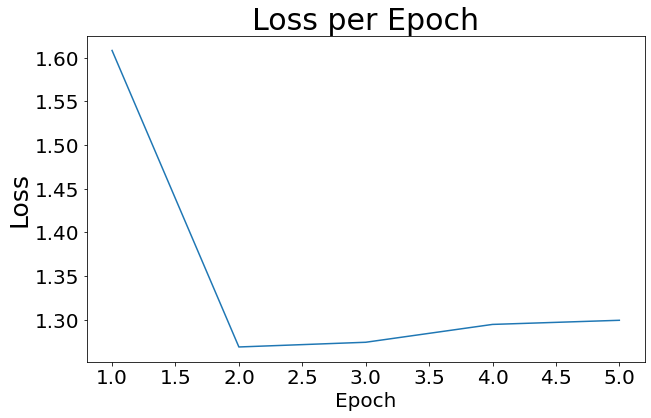

In [6]:
# Hyperparameters
n_steps = 1000
batch_size = 64
num_epochs = 5
learning_rate = 0.001
num_classes = len(np.unique(y_train))

# Create data loaders
train_loader = create_data_loader(X_train, y_train, n_steps, batch_size)
test_loader = create_data_loader(X_test, y_test, n_steps, batch_size)

# Initialize the model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = TimeSeriesCNN(n_steps, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()

losses_per_epoch = []

# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0
    
    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1

    avg_loss = epoch_loss / num_batches
    losses_per_epoch.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    
plt.figure(figsize=(10, 6))

plt.plot(range(1, num_epochs + 1), losses_per_epoch)
plt.xlabel('Epoch', fontsize=20)  
plt.ylabel('Loss', fontsize=25)  
plt.title('Loss per Epoch', fontsize=30) 

plt.xticks(fontsize=20)

plt.yticks(fontsize=20)

plt.show()

In [7]:
# Testing loop
correct = 0
total = 0

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.long)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"Test accuracy: {test_accuracy:.2f}%")

f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"F1 Score: {f1}")

Test accuracy: 33.09%
F1 Score: 0.1645249822751287


## load holdout test set here:

In [8]:
var_data_file_name = 'Capstone_final_TEST_dataset_for_ml_50ms.csv'
#var_n_rows_to_load = 1000000
#var_n_rows_to_load = 1000

#load all:
var_n_rows_to_load = None

var_verbose = True


var_return = Format_Test_Data(var_data_file_name, var_n_rows_to_load, var_scaler_from_training)

var_X_TEST_held_out = var_return[0]
var_y_TEST_held_out = var_return[1]

var_test_data_df_column_list = var_return[2]

original DataFrame:


,subject,label,time,ACC_1,ACC_2,ACC_3,ECG,EMG,EDA,Temp,...,tonic_rms,tonic_entropy,phasic_mean,phasic_std,phasic_min,phasic_max,phasic_energy,phasic_peaks,phasic_rms,phasic_entropy
0,15,1,1970-01-01 00:00:00.000,0.906806,0.072097,-0.103560,-0.153278,-0.003666,1.422719,33.526420,...,4.874447,-inf,3.5151,4.294627,0.0,17.361208,5.573183e+06,11,5.549752,11.47029
1,15,1,1970-01-01 00:00:00.050,0.900217,0.066109,-0.106011,0.007455,-0.005630,1.424125,33.524947,...,4.874447,-inf,3.5151,4.294627,0.0,17.361208,5.573183e+06,11,5.549752,11.47029
2,15,1,1970-01-01 00:00:00.100,0.903280,0.062154,-0.099771,-0.006536,0.000207,1.421912,33.530004,...,4.874447,-inf,3.5151,4.294627,0.0,17.361208,5.573183e+06,11,5.549752,11.47029
3,15,1,1970-01-01 00:00:00.150,0.904366,0.065137,-0.103537,0.001406,-0.000717,1.420550,33.530740,...,4.874447,-inf,3.5151,4.294627,0.0,17.361208,5.573183e+06,11,5.549752,11.47029
4,15,1,1970-01-01 00:00:00.200,0.903486,0.072971,-0.093983,0.026644,-0.003453,1.424833,33.534019,...,4.874447,-inf,3.5151,4.294627,0.0,17.361208,5.573183e+06,11,5.549752,11.47029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180944,17,4,1970-01-01 02:30:46.750,0.489731,-0.003503,-0.830869,-0.200391,-0.004282,7.028656,34.077069,...,0.000000,0.0,0.0000,0.000000,0.0,0.000000,0.000000e+00,0,0.000000,0.00000
180945,17,4,1970-01-01 02:30:46.800,0.486531,-0.004200,-0.832280,-0.117299,-0.003047,7.025888,34.078118,...,0.000000,0.0,0.0000,0.000000,0.0,0.000000,0.000000e+00,0,0.000000,0.00000
180946,17,4,1970-01-01 02:30:46.850,0.484634,-0.002354,-0.830251,-0.023418,-0.002673,7.024678,34.074848,...,0.000000,0.0,0.0000,0.000000,0.0,0.000000,0.000000e+00,0,0.000000,0.00000
180947,17,4,1970-01-01 02:30:46.900,0.486080,-0.007046,-0.823200,0.182867,-0.004349,7.023141,34.072500,...,0.000000,0.0,0.0000,0.000000,0.0,0.000000,0.000000e+00,0,0.000000,0.00000



column has Survey Data:
PANAS01_Active

column has Survey Data:
PANAS02_Distressed

column has Survey Data:
PANAS03_Interested

column has Survey Data:
PANAS04_Inspired

column has Survey Data:
PANAS05_Annoyed

column has Survey Data:
PANAS06_Strong

column has Survey Data:
PANAS07_Guilty

column has Survey Data:
PANAS08_Scared

column has Survey Data:
PANAS09_Hostile

column has Survey Data:
PANAS10_Excited

column has Survey Data:
PANAS11_Proud

column has Survey Data:
PANAS12_Irritable

column has Survey Data:
PANAS13_Enthusiastic

column has Survey Data:
PANAS14_Ashamed

column has Survey Data:
PANAS15_Alert

column has Survey Data:
PANAS16_Nervous

column has Survey Data:
PANAS17_Determined

column has Survey Data:
PANAS18_Attentive

column has Survey Data:
PANAS19_Jittery

column has Survey Data:
PANAS20_Afraid

column has Survey Data:
PANAS21_Stressed

column has Survey Data:
PANAS22_Frustrated

column has Survey Data:
PANAS23_Happy

column has Survey Data:
PANAS24_Angry
column

,ACC_1,ACC_2,ACC_3,ECG,EMG,EDA,Temp,Resp,age,height,...,tonic_peaks,tonic_rms,phasic_mean,phasic_std,phasic_min,phasic_max,phasic_energy,phasic_peaks,phasic_rms,label
0,0.906806,0.072097,-0.103560,-0.153278,-0.003666,1.422719,33.526420,-2.146432,28.0,186.0,...,7,4.874447,3.5151,4.294627,0.0,17.361208,5.573183e+06,11,5.549752,1
1,0.900217,0.066109,-0.106011,0.007455,-0.005630,1.424125,33.524947,-2.245135,28.0,186.0,...,7,4.874447,3.5151,4.294627,0.0,17.361208,5.573183e+06,11,5.549752,1
2,0.903280,0.062154,-0.099771,-0.006536,0.000207,1.421912,33.530004,-2.340611,28.0,186.0,...,7,4.874447,3.5151,4.294627,0.0,17.361208,5.573183e+06,11,5.549752,1
3,0.904366,0.065137,-0.103537,0.001406,-0.000717,1.420550,33.530740,-2.403085,28.0,186.0,...,7,4.874447,3.5151,4.294627,0.0,17.361208,5.573183e+06,11,5.549752,1
4,0.903486,0.072971,-0.093983,0.026644,-0.003453,1.424833,33.534019,-2.420306,28.0,186.0,...,7,4.874447,3.5151,4.294627,0.0,17.361208,5.573183e+06,11,5.549752,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180944,0.489731,-0.003503,-0.830869,-0.200391,-0.004282,7.028656,34.077069,13.653608,29.0,165.0,...,0,0.000000,0.0000,0.000000,0.0,0.000000,0.000000e+00,0,0.000000,4
180945,0.486531,-0.004200,-0.832280,-0.117299,-0.003047,7.025888,34.078118,13.842294,29.0,165.0,...,0,0.000000,0.0000,0.000000,0.0,0.000000,0.000000e+00,0,0.000000,4
180946,0.484634,-0.002354,-0.830251,-0.023418,-0.002673,7.024678,34.074848,14.038217,29.0,165.0,...,0,0.000000,0.0000,0.000000,0.0,0.000000,0.000000e+00,0,0.000000,4
180947,0.486080,-0.007046,-0.823200,0.182867,-0.004349,7.023141,34.072500,14.165998,29.0,165.0,...,0,0.000000,0.0000,0.000000,0.0,0.000000,0.000000e+00,0,0.000000,4


columns names after removal = 
Index(['ACC_1', 'ACC_2', 'ACC_3', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp', 'age',
       'height', 'weight', 'gender', 'dominant_hand', 'ACC_1_mean',
       'ACC_1_std', 'ACC_1_min', 'ACC_1_max', 'ACC_2_mean', 'ACC_2_std',
       'ACC_2_min', 'ACC_2_max', 'ACC_3_mean', 'ACC_3_std', 'ACC_3_min',
       'ACC_3_max', 'ECG_mean', 'ECG_std', 'ECG_min', 'ECG_max', 'EMG_mean',
       'EMG_std', 'EMG_min', 'EMG_max', 'EDA_mean', 'EDA_std', 'EDA_min',
       'EDA_max', 'Temp_mean', 'Temp_std', 'Temp_min', 'Temp_max', 'Resp_mean',
       'Resp_std', 'Resp_min', 'Resp_max', 'ECG_freq', 'eda_rise_mean',
       'eda_rise_std', 'eda_recovery_mean', 'eda_recovery_std', 'eda_scr_num',
       'eda_scr_freq', 'variance', 'rms', 'wl', 'zc', 'mav', 'l2_mean',
       'l2_std', 'l2_min', 'l2_max', 'l2_ptp', 'l2_sum', 'l2_energy',
       'l2_peaks', 'l2_rms', 'l2_lineintegral', 'l2_n_above_mean',
       'l2_n_below_mean', 'l2_n_sign_changes', 'l2_entropy', 'EDA.1',
       'tonic_me

In [9]:
print(var_train_data_df_column_list)
print(len(var_train_data_df_column_list))
print(var_test_data_df_column_list)
print(len(var_test_data_df_column_list))

Index(['ACC_1', 'ACC_2', 'ACC_3', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp', 'age',
       'height', 'weight', 'gender', 'dominant_hand', 'ACC_1_mean',
       'ACC_1_std', 'ACC_1_min', 'ACC_1_max', 'ACC_2_mean', 'ACC_2_std',
       'ACC_2_min', 'ACC_2_max', 'ACC_3_mean', 'ACC_3_std', 'ACC_3_min',
       'ACC_3_max', 'ECG_mean', 'ECG_std', 'ECG_min', 'ECG_max', 'EMG_mean',
       'EMG_std', 'EMG_min', 'EMG_max', 'EDA_mean', 'EDA_std', 'EDA_min',
       'EDA_max', 'Temp_mean', 'Temp_std', 'Temp_min', 'Temp_max', 'Resp_mean',
       'Resp_std', 'Resp_min', 'Resp_max', 'ECG_freq', 'eda_rise_mean',
       'eda_rise_std', 'eda_recovery_mean', 'eda_recovery_std', 'eda_scr_num',
       'eda_scr_freq', 'variance', 'rms', 'wl', 'zc', 'mav', 'l2_mean',
       'l2_std', 'l2_min', 'l2_max', 'l2_ptp', 'l2_sum', 'l2_energy',
       'l2_peaks', 'l2_rms', 'l2_lineintegral', 'l2_n_above_mean',
       'l2_n_below_mean', 'l2_n_sign_changes', 'l2_entropy', 'EDA.1',
       'tonic_mean', 'tonic_std', 'tonic_min', 

In [10]:
var_X_TEST_held_out_df = pd.DataFrame(var_X_TEST_held_out,columns=var_train_data_df_column_list[:-1])
display(var_X_TEST_held_out_df)
print(var_X_TEST_held_out_df.shape)

,ACC_1,ACC_2,ACC_3,ECG,EMG,EDA,Temp,Resp,age,height,...,tonic_energy,tonic_peaks,tonic_rms,phasic_mean,phasic_std,phasic_min,phasic_max,phasic_energy,phasic_peaks,phasic_rms
0,0.945403,0.949420,0.866942,0.460134,0.959969,0.069863,0.993114,0.591228,0.3,0.842105,...,-0.021559,0.000000,0.037353,0.209483,0.000016,1.0,-0.082240,-0.018475,0.000000,0.046066
1,0.944573,0.948568,0.866615,0.515052,0.958709,0.069932,0.993109,0.590008,0.3,0.842105,...,-0.021559,0.000000,0.037353,0.209483,0.000016,1.0,-0.082240,-0.018475,0.000000,0.046066
2,0.944959,0.948005,0.867448,0.510271,0.962454,0.069824,0.993125,0.588829,0.3,0.842105,...,-0.021559,0.000000,0.037353,0.209483,0.000016,1.0,-0.082240,-0.018475,0.000000,0.046066
3,0.945095,0.948430,0.866945,0.512985,0.961861,0.069757,0.993128,0.588057,0.3,0.842105,...,-0.021559,0.000000,0.037353,0.209483,0.000016,1.0,-0.082240,-0.018475,0.000000,0.046066
4,0.944985,0.949545,0.868220,0.521608,0.960106,0.069967,0.993138,0.587844,0.3,0.842105,...,-0.021559,0.000000,0.037353,0.209483,0.000016,1.0,-0.082240,-0.018475,0.000000,0.046066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180944,0.892877,0.938663,0.769884,0.444037,0.959574,0.345145,0.994897,0.786436,0.4,-0.263158,...,-0.061617,-0.333333,-0.362405,-0.415898,-0.318894,1.0,-0.270883,-0.053654,-0.366667,-0.344216
180945,0.892474,0.938563,0.769696,0.472427,0.960366,0.345009,0.994900,0.788767,0.4,-0.263158,...,-0.061617,-0.333333,-0.362405,-0.415898,-0.318894,1.0,-0.270883,-0.053654,-0.366667,-0.344216
180946,0.892235,0.938826,0.769966,0.504503,0.960606,0.344950,0.994890,0.791188,0.4,-0.263158,...,-0.061617,-0.333333,-0.362405,-0.415898,-0.318894,1.0,-0.270883,-0.053654,-0.366667,-0.344216
180947,0.892417,0.938158,0.770907,0.574985,0.959531,0.344875,0.994882,0.792767,0.4,-0.263158,...,-0.061617,-0.333333,-0.362405,-0.415898,-0.318894,1.0,-0.270883,-0.053654,-0.366667,-0.344216


(180949, 86)


In [11]:
display(var_y_TEST_held_out)
print(var_y_TEST_held_out.shape)

array([0, 0, 0, ..., 3, 3, 3])

(180949,)


In [12]:
test_heldout_loader = create_data_loader(var_X_TEST_held_out, var_y_TEST_held_out, n_steps, batch_size)

## held out testing loop here:

In [13]:
# Testing loop
correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_heldout_loader:
        inputs, labels = batch
        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.long)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"Test (heldout) accuracy: {test_accuracy:.2f}%")


f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"F1 Score: {f1}")

Test (heldout) accuracy: 12.36%
F1 Score: 0.027193581568637746


### 